In [1]:
import sys
#sys.path.append('/home/rasool/anaconda3/lib/python3.8/site-packages')

import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

from scipy import stats
import numpy as np
import pykalman
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

Using TensorFlow backend.


In [2]:
!pip list

Package                   Version
------------------------- -----------
absl-py                   2.2.1
anyio                     4.2.0
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 2.0.5
astunparse                1.6.3
async-lru                 2.0.4
attrs                     24.2.0
Babel                     2.11.0
backcall                  0.2.0
beautifulsoup4            4.12.3
bleach                    4.1.0
Brotli                    1.0.9
cachetools                4.2.4
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.3.2
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.1.1
cycler                    0.12.1
debugpy                   1.6.7
decorator                 5.1.1
defusedxml                0.7.1
exceptiongroup            1.2.0
executing                 0.8.3
fastjsonschema            2.16.2
fonttools                 4.56.0
gast               

In [3]:
def calculate_snr(signal, noise):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels (dB).

    Parameters:
    signal (array-like): The signal data.
    noise (array-like): The noise data.

    Returns:
    float: The SNR in decibels (dB).
    """
    # Ensure the inputs are numpy arrays
    signal = np.asarray(signal)
    noise = np.asarray(noise)

    # Calculate the power of the signal and noise
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)

    # Avoid division by zero
    if noise_power == 0:
        raise ValueError("Noise power is zero. Cannot calculate SNR.")

    # Calculate the SNR in decibels
    snr_db = 10 * np.log10(signal_power / noise_power)

    return snr_db

In [4]:
def denoise_hierarchical_kalman_adaptive(data, beat_size=180, initial_process_noise=0.5, learning_rate=0.01):
    """Adaptive hierarchical Kalman filter with simplified evolution priors."""
    
    # Calculate original SNR
    noise_original = data - np.mean(data)  # Noise is the deviation from the mean
    original_snr = calculate_snr(data, noise_original)
    print(f"Original SNR: {original_snr:.2f} dB")

    process_noise = initial_process_noise  # Initialize process noise

    # Pad the data to make its length a multiple of beat_size
    padding_length = (beat_size - len(data) % beat_size) % beat_size
    if padding_length != 0:
        data_padded = np.pad(data, (0, padding_length), mode='edge')  # Pad with edge values
    else:
        data_padded = data

    # 1. Lower Level (Beat-Level Kalman Filtering)
    denoised_beats = []
    for i in range(0, len(data_padded) - beat_size + 1, beat_size):
        beat = data_padded[i:i + beat_size]

        kf_beat = pykalman.KalmanFilter(
            transition_matrices=[[1]],
            observation_matrices=[[1]],
            transition_covariance=[[process_noise]],  # Use the current process noise
            observation_covariance=[[1]],  # Tune this
            initial_state_mean=[beat[0]],
            initial_state_covariance=[[1]],
        )
        denoised_beat, _ = kf_beat.smooth(beat)

        # Update process noise based on residual error (simplified adaptation)
        residual = beat - denoised_beat.flatten()  # Calculate residual
        process_noise += learning_rate * np.mean(residual**2)  # Update process noise

        denoised_beats.extend(denoised_beat.flatten())

    denoised_beats = np.array(denoised_beats)

    # Truncate the denoised signal to match the original data length
    denoised_signal = denoised_beats[:len(data)]

    # 2. Higher Level (Signal-Level Kalman Filtering - Remains the same)
    kf_signal = pykalman.KalmanFilter(
        transition_matrices=[[1]],
        observation_matrices=[[1]],
        transition_covariance=[[0.001]],  # Tune this
        observation_covariance=[[0.1]],  # Tune this
        initial_state_mean=[denoised_signal[0]],
        initial_state_covariance=[[1]],
    )
    denoised_signal, _ = kf_signal.smooth(denoised_signal)

    # Calculate denoised SNR
    noise_denoised = data - denoised_signal.flatten()  # Noise is the difference between original and denoised
    denoised_snr = calculate_snr(denoised_signal, noise_denoised)
    print(f"Denoised SNR: {denoised_snr:.2f} dB")

    # Calculate SNR improvement
    snr_improvement = denoised_snr - original_snr
    print(f"SNR Improvement: {snr_improvement:.2f} dB")

    return denoised_signal.flatten()

In [5]:
# Path and parameters
path = 'mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0] * n_classes

X = list()
y = list()

In [6]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv, .txt
records = list()
annotations = list()
filenames.sort()

# Segregating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if file_extension == '.csv':
        records.append(path + filename + file_extension)
    # *.txt
    else:
        annotations.append(path + filename + file_extension)

Original SNR: 27.94 dB
Denoised SNR: 30.70 dB
SNR Improvement: 2.77 dB


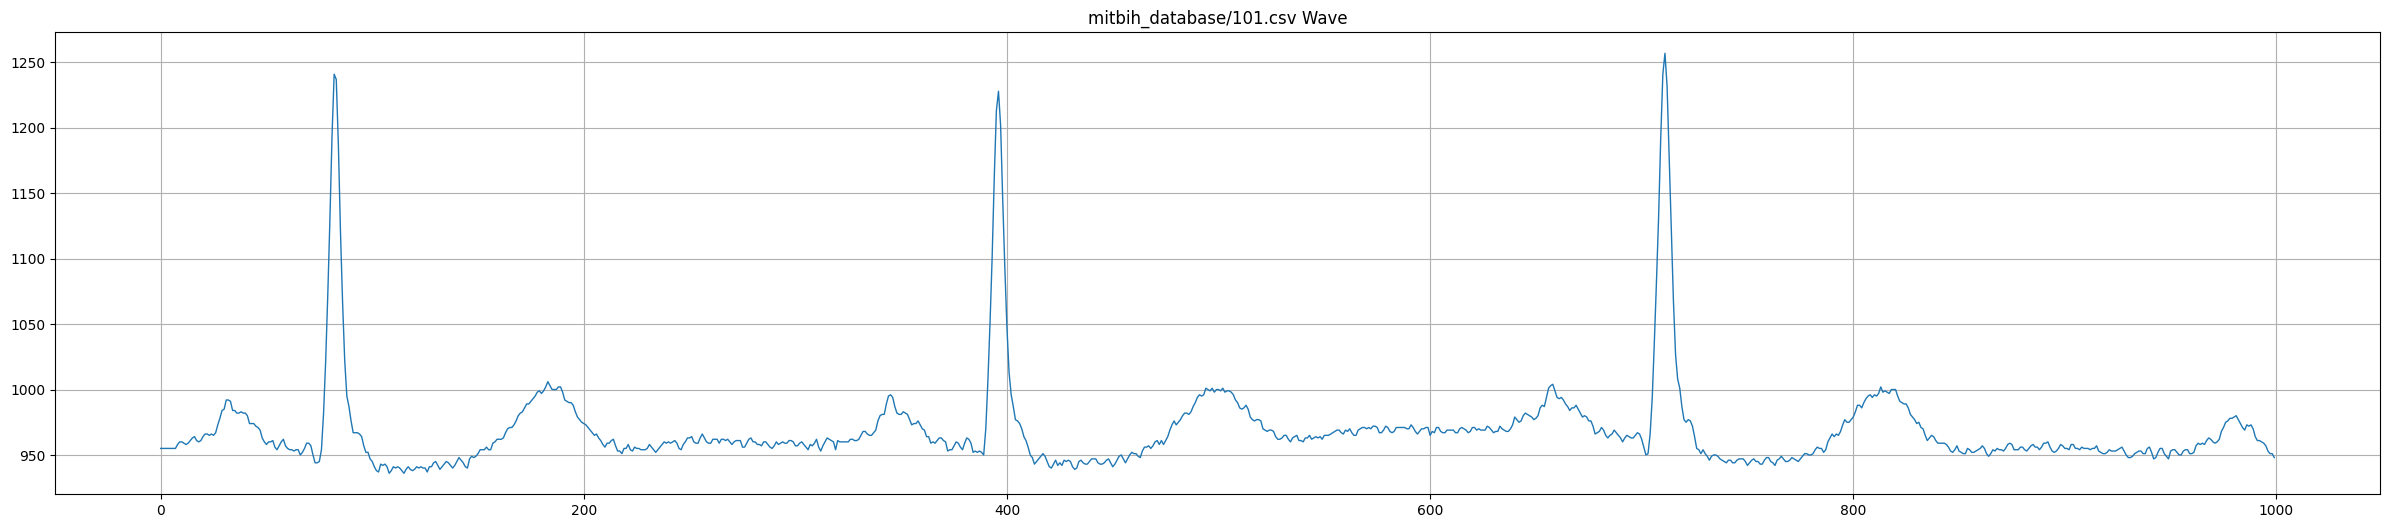

Original SNR: 25.36 dB
Denoised SNR: 30.33 dB
SNR Improvement: 4.96 dB


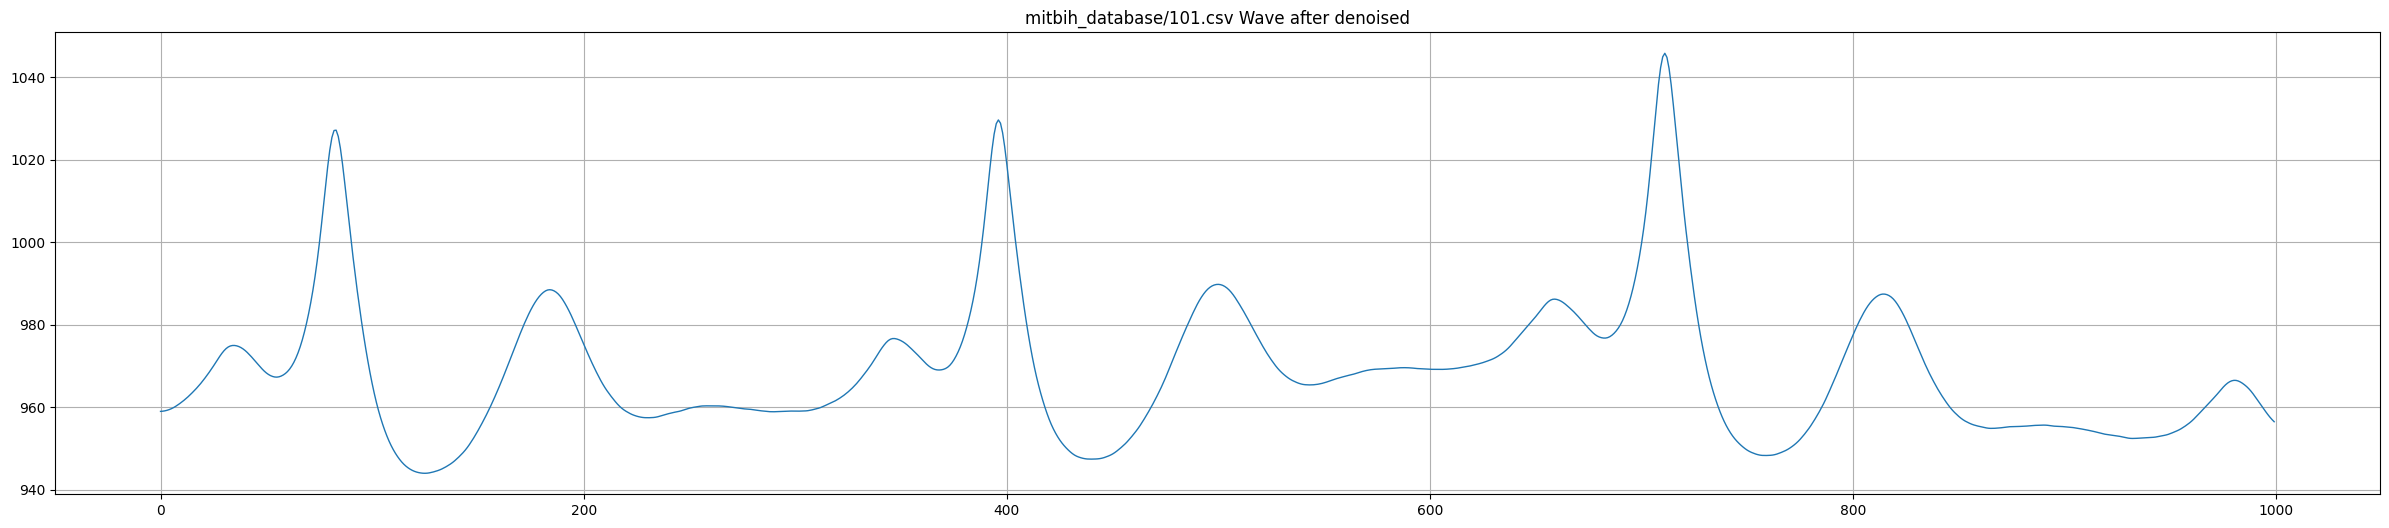

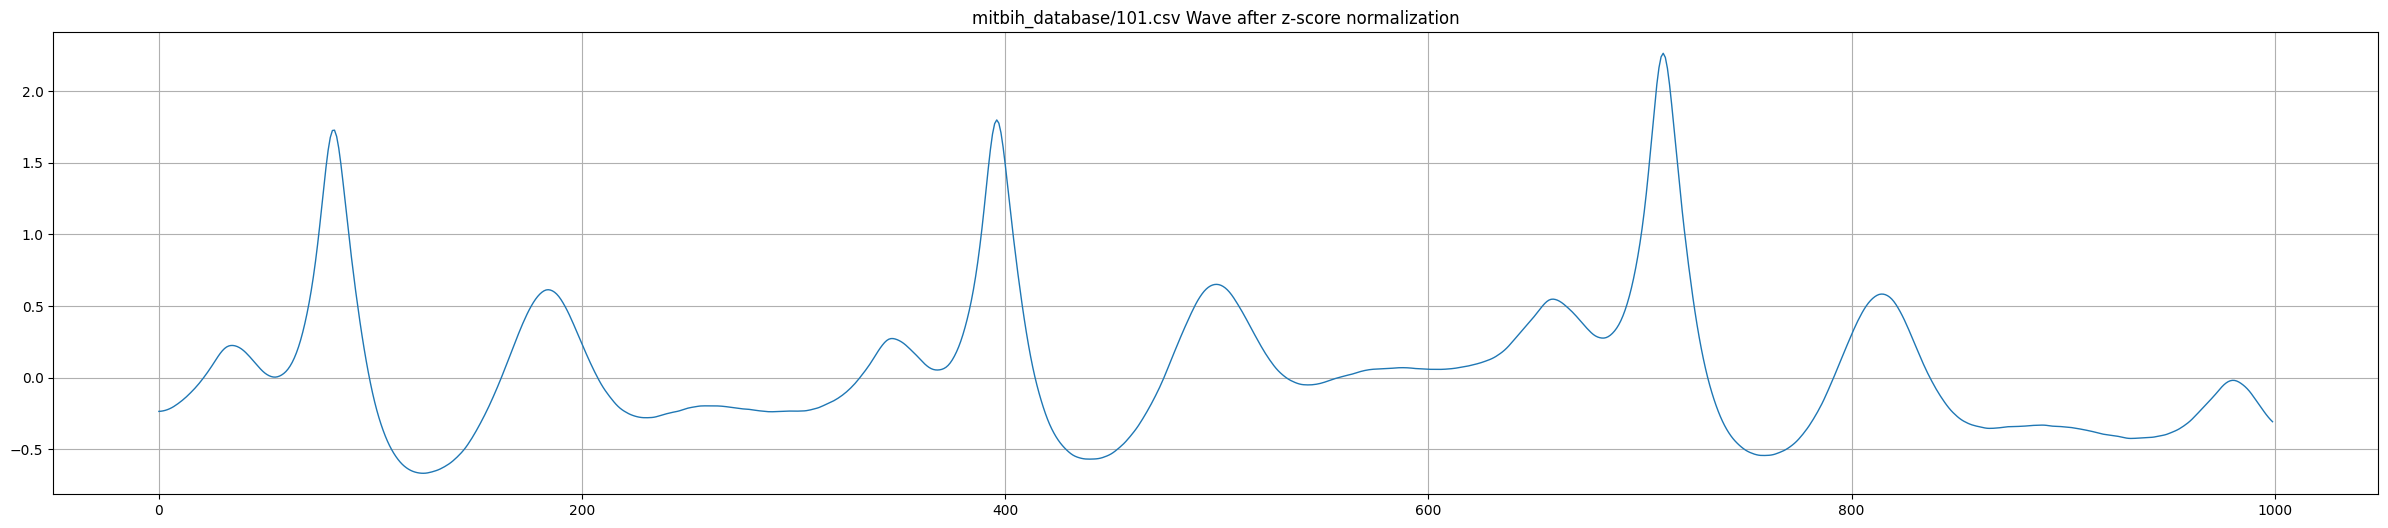

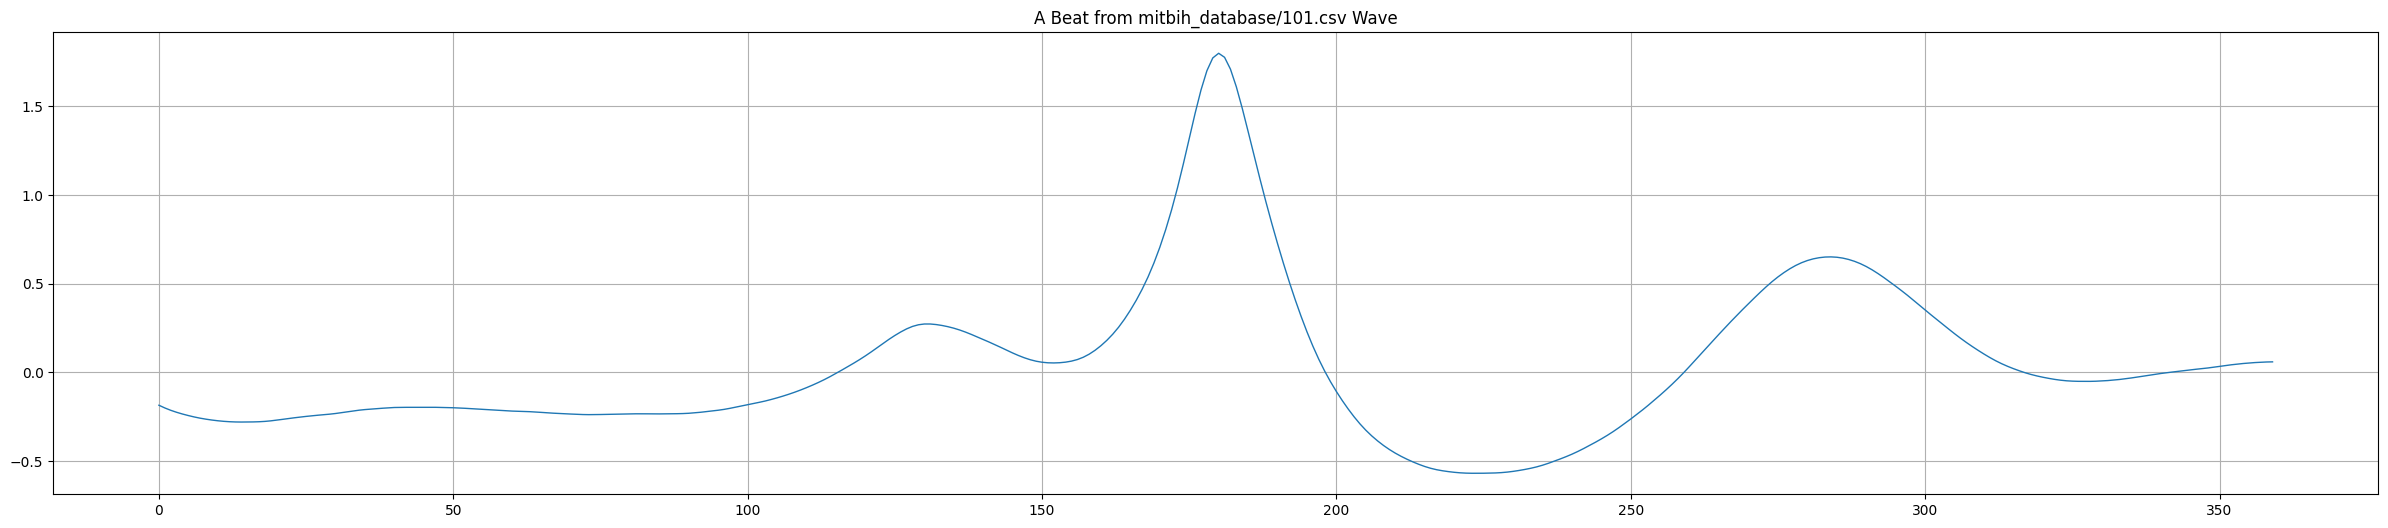

Original SNR: 28.17 dB
Denoised SNR: 34.65 dB
SNR Improvement: 6.48 dB
Original SNR: 23.65 dB
Denoised SNR: 27.19 dB
SNR Improvement: 3.54 dB
Original SNR: 25.83 dB
Denoised SNR: 32.33 dB
SNR Improvement: 6.49 dB
Original SNR: 21.67 dB
Denoised SNR: 29.20 dB
SNR Improvement: 7.53 dB
Original SNR: 22.58 dB
Denoised SNR: 27.90 dB
SNR Improvement: 5.32 dB
Original SNR: 15.24 dB
Denoised SNR: 24.45 dB
SNR Improvement: 9.20 dB
Original SNR: 24.24 dB
Denoised SNR: 34.65 dB
SNR Improvement: 10.42 dB
Original SNR: 19.86 dB
Denoised SNR: 26.66 dB
SNR Improvement: 6.80 dB
Original SNR: 25.71 dB
Denoised SNR: 34.20 dB
SNR Improvement: 8.49 dB
Original SNR: 25.69 dB
Denoised SNR: 31.91 dB
SNR Improvement: 6.23 dB
Original SNR: 21.64 dB
Denoised SNR: 26.99 dB
SNR Improvement: 5.35 dB
Original SNR: 29.25 dB
Denoised SNR: 37.29 dB
SNR Improvement: 8.05 dB
Original SNR: 22.13 dB
Denoised SNR: 25.84 dB
SNR Improvement: 3.71 dB
Original SNR: 16.09 dB
Denoised SNR: 21.93 dB
SNR Improvement: 5.84 dB
Origi

In [7]:
# Records for Kalman Filter
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')  # Read CSV file
        row_index = -1
        for row in spamreader:
            if row_index >= 0:
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example of the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:1000])
        plt.show()
        
    # Denoise the signals
    signals = denoise_hierarchical_kalman_adaptive(signals)
    
    # Plot an example of the denoised signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave after denoised")
        plt.plot(signals[0:1000])
        plt.show()
        
    # Normalize the signals using z-score
    signals = stats.zscore(signals)
    
    # Plot an example of the normalized signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave after z-score normalization")
        plt.plot(signals[0:1000])
        plt.show()
    
    # Read annotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)):  # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = list(filter(None, splitted))
            splitted_iter = iter(splitted)  # Convert the list to an iterator
            next(splitted_iter)  # Time... Clipping
            pos = int(next(splitted_iter))  # Sample ID
            arrhythmia_type = next(splitted_iter)  # Type
            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if window_size <= pos and pos < (len(signals) - window_size):
                    beat = signals[pos - window_size:pos + window_size]  # REPLACE WITH R-PEAK DETECTION
                    # Plot an example of a beat    
                    if r == 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# Data shape
print(np.shape(X), np.shape(y))

In [883]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))

ValueError: could not broadcast input array from shape (363,) into shape (362,)

# Dataset Before Balancing

In [884]:
import pandas as pd
import matplotlib.pyplot as plt

# Append the class labels to the data
for i in range(len(X)):
    X[i] = np.append(X[i], y[i])

print(np.shape(X))

# Convert to DataFrame
X_train_df = pd.DataFrame(X)

# Get the distribution of class labels
per_class = X_train_df[X_train_df.shape[1] - 1].value_counts()
print(per_class)

# Dynamically generate labels and colors based on the unique classes
unique_classes = per_class.index
labels = [classes[int(cls)] for cls in unique_classes]  # Map class indices to labels
colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'][:len(unique_classes)]  # Use the first N colors

# Plot the distribution of class labels
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=labels, colors=colors, autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

ValueError: could not broadcast input array from shape (363,) into shape (362,)

# Dataset After Balancing

In [885]:
!pip uninstall imbalanced-learn -y

Found existing installation: imbalanced-learn 0.8.0
Uninstalling imbalanced-learn-0.8.0:
  Successfully uninstalled imbalanced-learn-0.8.0


In [886]:
!pip install imbalanced-learn==0.8.0

  Using cached imbalanced_learn-0.8.0-py3-none-any.whl.metadata (11 kB)
Using cached imbalanced_learn-0.8.0-py3-none-any.whl (206 kB)


Class Distribution After Undersampling:
class
0    5000
1    6457
2    5486
3     931
4    5703
Name: count, dtype: int64


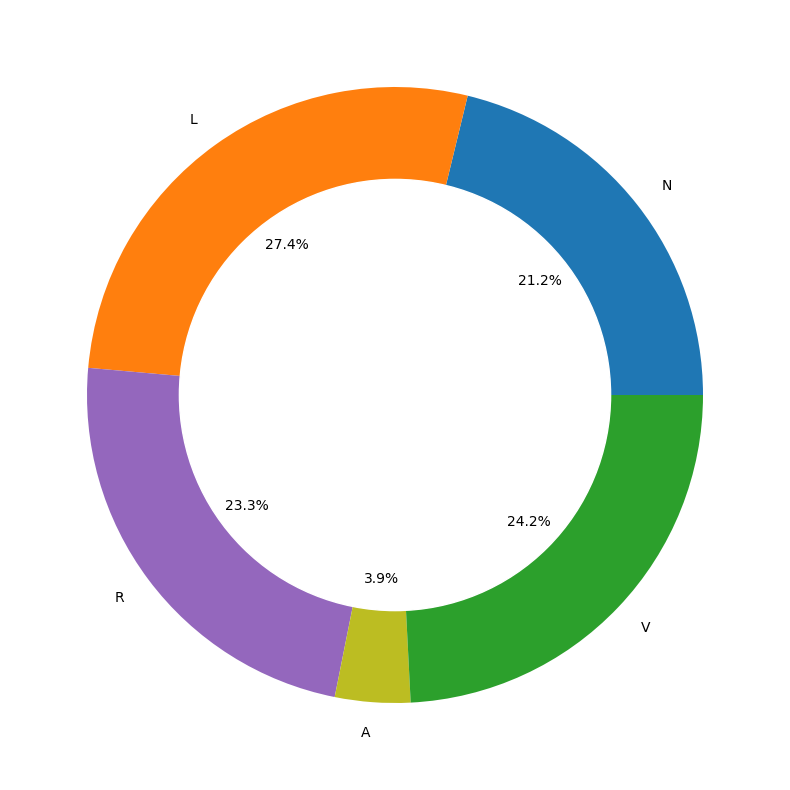

X_train : (18861, 363)
X_val   : (4716, 363)
X_test  : (19647, 362)


In [887]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Assuming X and y are predefined (features and labels)
# -----------------------------------------------------

# 1. Convert X (list of arrays) into a NumPy array
X = np.array(X)  # Now X is a 2D array with shape (n_samples, n_features + 1)

# 2. Split into train/test sets (stratified split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Undersample the majority class (0) ONLY on the training set
undersampler = RandomUnderSampler(
    sampling_strategy={0: 5000},  # Keep 5000 samples of class 0
    random_state=42
)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# 4. Combine undersampled training data into a DataFrame
train_under_df = pd.DataFrame(X_train_under)
train_under_df['class'] = y_train_under  # Add class column

# 5. Plot distribution after undersampling
per_class = train_under_df['class'].value_counts().sort_index()
print("Class Distribution After Undersampling:")
print(per_class)

plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], 
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'],
        autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# 6. Split the undersampled data into final train/validation sets
train_final, val = train_test_split(train_under_df, test_size=0.2, random_state=42)

print("X_train :", train_final.shape)
print("X_val   :", val.shape)
print("X_test  :", X_test.shape)  # Now works because X_test is a NumPy array

# Splitting the Dataset

In [888]:
#train, test = train_test_split(X_train_df, test_size=0.20)
train, test = train_final, X_test

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))


X_train :  (18861, 363)
X_test  :  (19647, 362)


In [889]:
# دالة لإضافة ضوضاء خفيفة للإشارة
def add_noise(signal, noise_level=0.01):
    return signal + np.random.normal(0, noise_level, size=signal.shape)

# تطبيق الضوضاء على جزء من بيانات التدريب
X_train_aug = np.array([add_noise(x) for x in X_train])

# دمج البيانات الأصلية مع المعززة
X_train = np.concatenate((X_train, X_train_aug))
y_train = np.concatenate((y_train, y_train))  # نكرر نفس التسميات


# Convert labels to one-hot encoding

In [890]:
# 1. Convert X_test and y_test into a DataFrame for consistency
test_df = pd.DataFrame(X_test)
test_df['class'] = y_test  # Add the 'class' column to the test set

# 2. Assign train and test DataFrames
train = train_final  # Already a DataFrame with 'class' column
test = test_df       # Now a DataFrame with 'class' column

# 3. Extract class labels by name
target_train = train['class']
target_test = test['class']

# 4. Convert to one-hot encoding
train_y = to_categorical(target_train, num_classes=5)
test_y = to_categorical(target_test, num_classes=5)

print("Train Y shape:", train_y.shape)
print("Test Y shape:", test_y.shape)


Train Y shape: (18861, 5)
Test Y shape: (19647, 5)


# Reshape the Dataset

In [891]:
# Prepare input data (drop the last column, which is the label)
train_x = train.iloc[:,:train.shape[1]-1].values  # Shape: (20000, 361)
test_x = test.iloc[:,:test.shape[1]-1].values    # Shape: (5000, 361)



# Reshape input data to (samples, sequence_length, 1)
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)

print("Train X shape:", train_x.shape)  # Should be (20000, 361, 1)
print("Test X shape:", test_x.shape)    # Should be (5000, 361, 1)

Train X shape: (18861, 362, 1)
Test X shape: (19647, 362, 1)


# Building the Model

In [893]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the teacher model
def build_teacher_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Add dropout
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Add dropout
    x = layers.Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

In [894]:
# Define the student model
def build_student_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)  # Add dropout
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

In [763]:
import tensorflow as tf
import numpy as np
import random
import os

def set_seeds(seed=42):
    # Set Python and NumPy seeds
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
    # For TensorFlow 2.8+ users
    if hasattr(tf.config.experimental, 'enable_op_determinism'):
        tf.config.experimental.enable_op_determinism()
    else:
        # For older versions
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Initialize seeds before model creation
set_seeds(42)

In [895]:
# Build and compile the teacher model
teacher_model = build_teacher_model(input_shape=(362, 1), num_classes=5)
teacher_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [896]:
teacher_model.summary()

Model: "model_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_134 (InputLayer)       [(None, 362, 1)]          0         
_________________________________________________________________
conv1d_358 (Conv1D)          (None, 362, 64)           256       
_________________________________________________________________
max_pooling1d_226 (MaxPoolin (None, 181, 64)           0         
_________________________________________________________________
dropout_183 (Dropout)        (None, 181, 64)           0         
_________________________________________________________________
conv1d_359 (Conv1D)          (None, 181, 128)          24704     
_________________________________________________________________
max_pooling1d_227 (MaxPoolin (None, 90, 128)           0         
_________________________________________________________________
dropout_184 (Dropout)        (None, 90, 128)           0 

In [897]:
# Define the Adam optimizer with a custom learning rate
learning_rate = 0.001  # Adjust this value (default is 0.001)
optimizer = Adam(learning_rate=learning_rate)


# Build and compile the teacher model
teacher_model = build_teacher_model(input_shape=(362, 1), num_classes=5)
teacher_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[
        'accuracy',
        Precision(name='precision'),  
        Recall(name='recall')         
    ])

In [898]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# إعداد EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# إعداد ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# تدريب النموذج مع callbacks
print("Training the teacher model...")
history_teacher = teacher_model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop, reduce_lr]
)


Training the teacher model...
Epoch 1/100
148/148 [==============================] - 35s 235ms/step - loss: 1.0854 - accuracy: 0.5605 - precision: 0.8863 - recall: 0.2785 - val_loss: 0.2975 - val_accuracy: 0.9427 - val_precision: 0.9577 - val_recall: 0.9325 - lr: 0.0010
Epoch 2/100
148/148 [==============================] - 31s 207ms/step - loss: 0.2734 - accuracy: 0.9195 - precision: 0.9293 - recall: 0.9110 - val_loss: 0.1731 - val_accuracy: 0.9510 - val_precision: 0.9533 - val_recall: 0.9488 - lr: 0.0010
Epoch 3/100
148/148 [==============================] - 32s 214ms/step - loss: 0.1606 - accuracy: 0.9498 - precision: 0.9542 - recall: 0.9453 - val_loss: 0.1643 - val_accuracy: 0.9574 - val_precision: 0.9576 - val_recall: 0.9567 - lr: 0.0010
Epoch 4/100
148/148 [==============================] - 30s 203ms/step - loss: 0.1173 - accuracy: 0.9629 - precision: 0.9645 - recall: 0.9609 - val_loss: 0.0434 - val_accuracy: 0.9912 - val_precision: 0.9916 - val_recall: 0.9907 - lr: 0.0010
Epoch 

In [899]:
# Train the teacher model
#print("Training the teacher model...")
#history_teacher = teacher_model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=30, batch_size=128)

# Plot The Loss

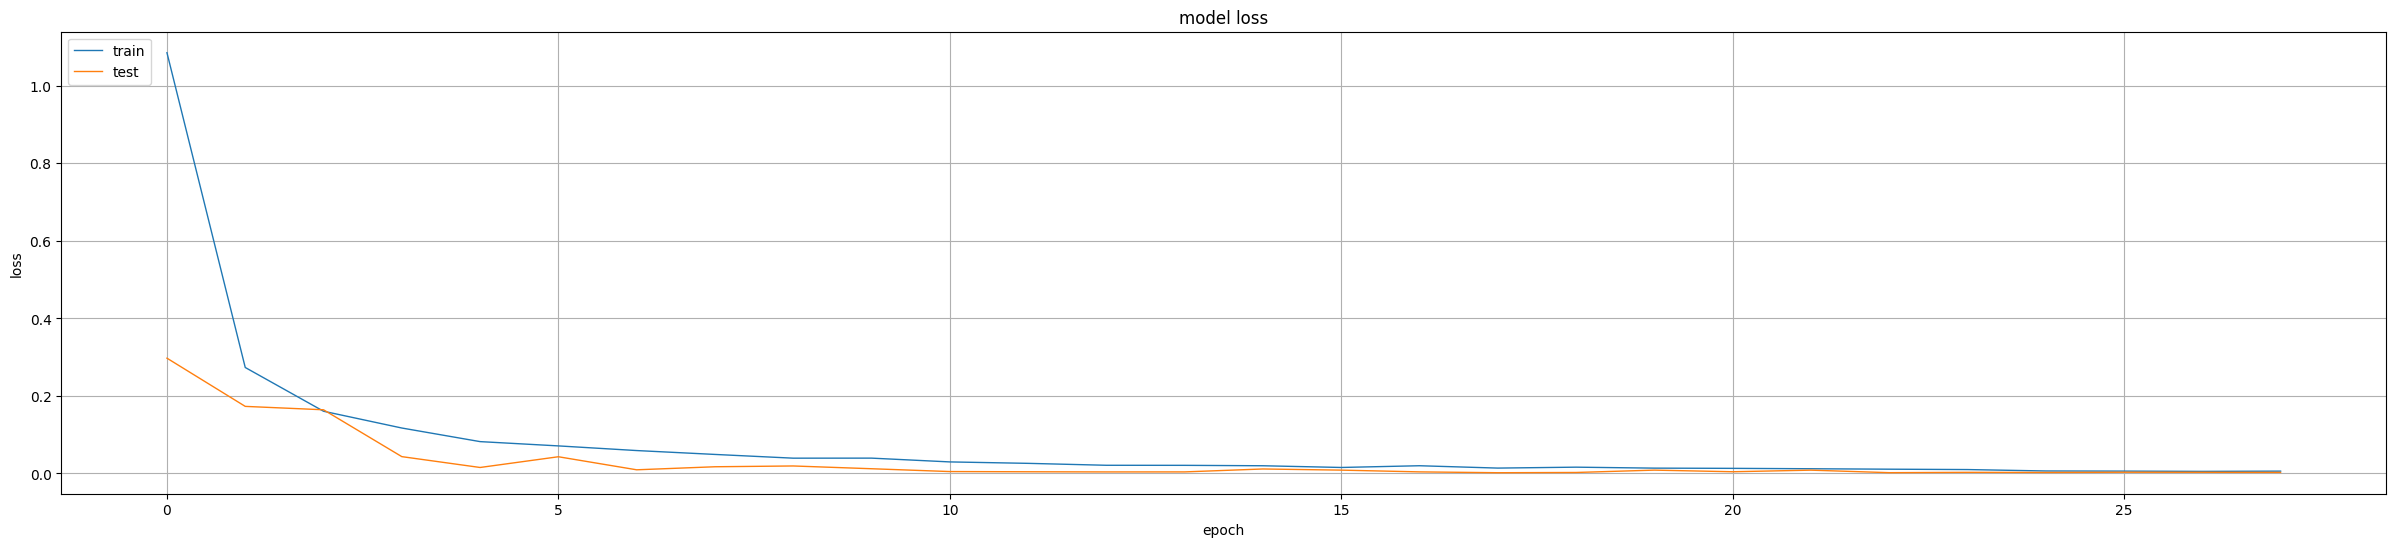

In [900]:
# summarize history for loss
plt.plot(history_teacher.history['loss'])
plt.plot(history_teacher.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the Accuracy

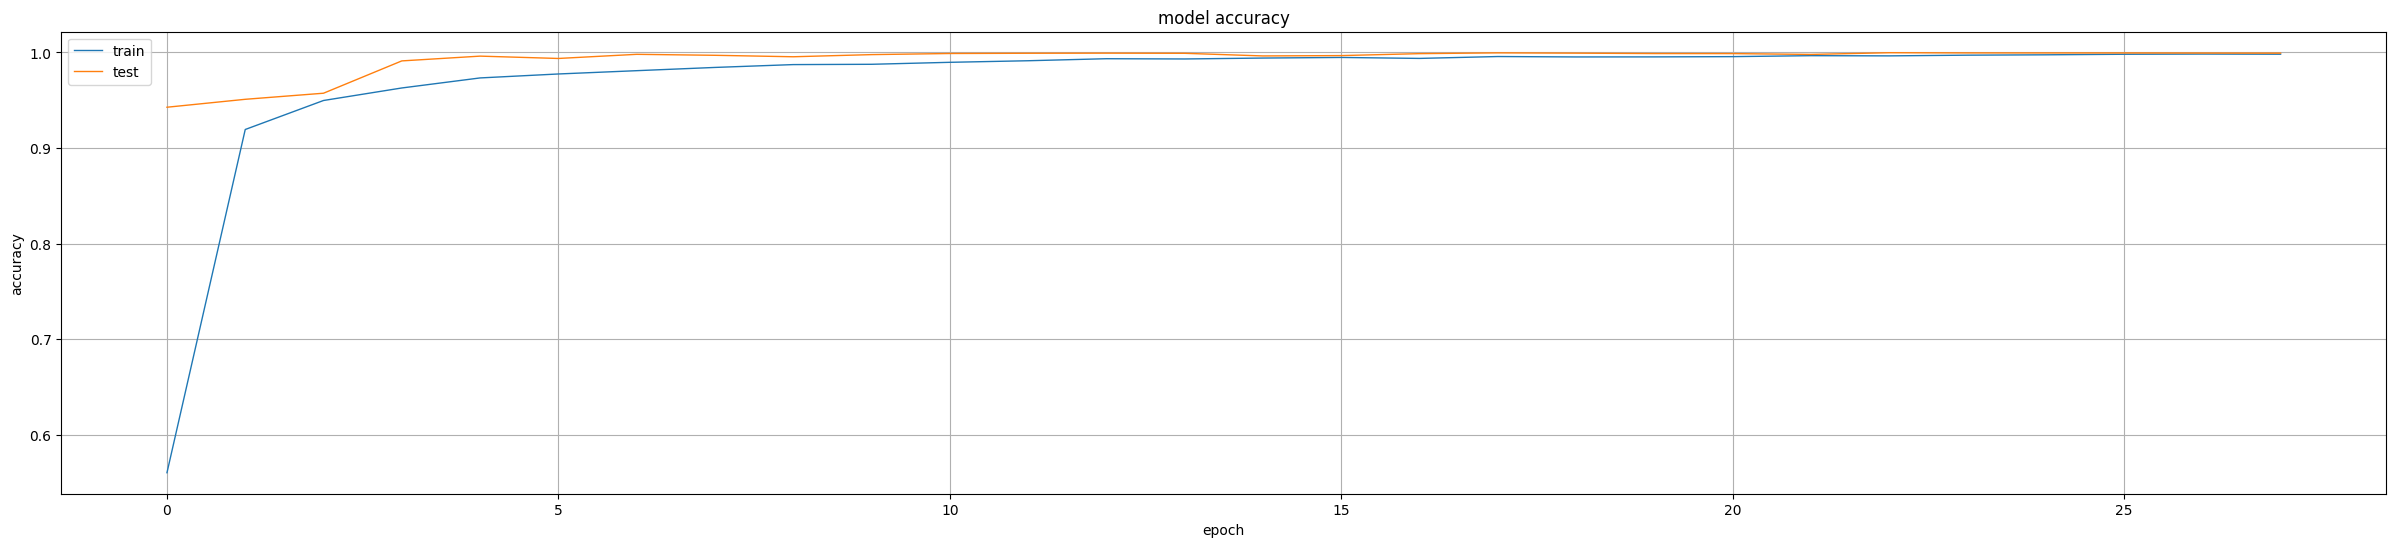

In [901]:
# summarize history for accuracy
plt.plot(history_teacher.history['accuracy'])
plt.plot(history_teacher.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

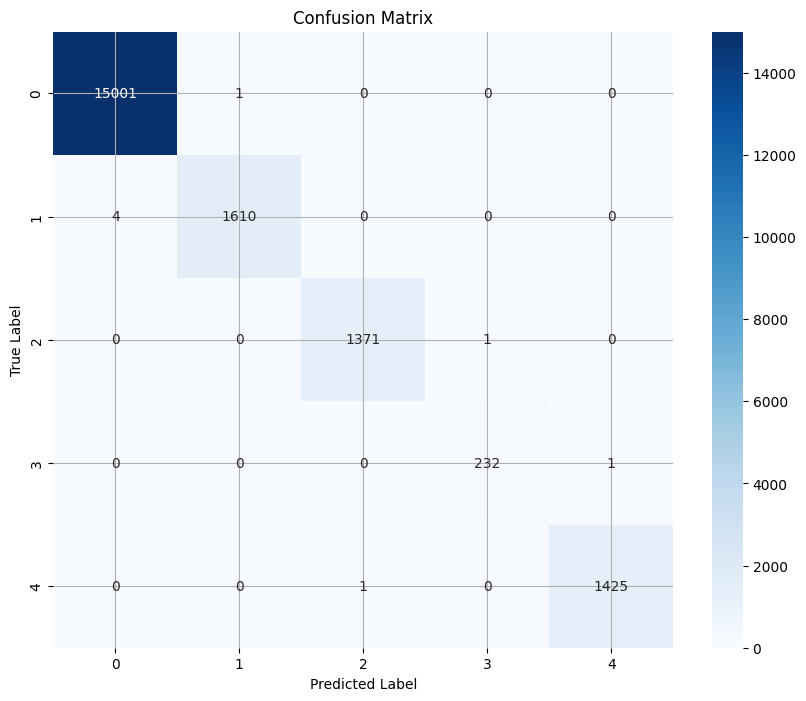


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15002
           1       1.00      1.00      1.00      1614
           2       1.00      1.00      1.00      1372
           3       1.00      1.00      1.00       233
           4       1.00      1.00      1.00      1426

    accuracy                           1.00     19647
   macro avg       1.00      1.00      1.00     19647
weighted avg       1.00      1.00      1.00     19647



In [902]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = teacher_model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(5), yticklabels=range(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Optional: Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(5)]))

In [903]:
!pip install seaborn


In [833]:
set_seeds(42)

In [904]:
# Build the student model
student_model = build_student_model(input_shape=(362, 1), num_classes=5)

In [905]:
student_model.summary()

Model: "model_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_136 (InputLayer)       [(None, 362, 1)]          0         
_________________________________________________________________
conv1d_364 (Conv1D)          (None, 362, 32)           128       
_________________________________________________________________
max_pooling1d_230 (MaxPoolin (None, 181, 32)           0         
_________________________________________________________________
dropout_187 (Dropout)        (None, 181, 32)           0         
_________________________________________________________________
conv1d_365 (Conv1D)          (None, 181, 64)           6208      
_________________________________________________________________
global_average_pooling1d_135 (None, 64)                0         
_________________________________________________________________
dense_272 (Dense)            (None, 128)               83

In [906]:
# Define the distillation loss
def distillation_loss(y_true, y_pred, teacher_logits, temperature=2.0):
    # Soften the teacher's and student's logits using temperature scaling
    teacher_probs = tf.nn.softmax(teacher_logits / temperature)
    student_probs = tf.nn.softmax(y_pred / temperature)
    
    # KL divergence loss
    kl_loss = tf.keras.losses.KLDivergence()(teacher_probs, student_probs)
    
    # Cross-entropy loss with ground truth labels
    ce_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    
    # Combine the losses
    return 0.5 * kl_loss + 0.5 * ce_loss



# Custom training loop for distillation
optimizer = tf.keras.optimizers.Adam()
temperature = 2.0

# Create a tf.data.Dataset for batching
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(128)

In [907]:
# Training step (updated to compute accuracy)
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        # Forward pass of student
        student_pred = student_model(x_batch, training=True)
        
        # Forward pass of teacher (no gradient updates)
        teacher_pred = teacher_model(x_batch, training=False)
        
        # Compute distillation loss
        loss = distillation_loss(y_batch, student_pred, teacher_pred, temperature)
    
    # Compute accuracy
    true_labels = tf.argmax(y_batch, axis=1)              # Convert one-hot to class indices
    pred_labels = tf.argmax(student_pred, axis=1)         # Predicted class indices
    accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, true_labels), tf.float32))
    
    # Compute gradients and update student weights
    gradients = tape.gradient(loss, student_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))
    
    return loss, accuracy  # Return both loss and accuracy

# Training loop (updated to track accuracy)
print("Training the student model using Knowledge Distillation...")
for epoch in range(100):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(train_dataset):
        batch_loss, batch_accuracy = train_step(x_batch, y_batch)
        epoch_loss += batch_loss
        epoch_accuracy += batch_accuracy
    epoch_loss /= (batch_idx + 1)
    epoch_accuracy /= (batch_idx + 1)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Compile the student model for evaluation
print("Compiling the student model for evaluation...")
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    
    
# Evaluate the student model
print("Evaluating the student model...")
test_loss, test_acc = student_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Training the student model using Knowledge Distillation...
Epoch 1, Loss: 0.6916, Accuracy: 0.4156
Epoch 2, Loss: 0.5912, Accuracy: 0.5258
Epoch 3, Loss: 0.5549, Accuracy: 0.5575
Epoch 4, Loss: 0.4862, Accuracy: 0.6245
Epoch 5, Loss: 0.3845, Accuracy: 0.7424
Epoch 6, Loss: 0.3067, Accuracy: 0.8074
Epoch 7, Loss: 0.2578, Accuracy: 0.8397
Epoch 8, Loss: 0.2224, Accuracy: 0.8591
Epoch 9, Loss: 0.2024, Accuracy: 0.8698
Epoch 10, Loss: 0.1820, Accuracy: 0.8829
Epoch 11, Loss: 0.1703, Accuracy: 0.8895
Epoch 12, Loss: 0.1585, Accuracy: 0.8971
Epoch 13, Loss: 0.1459, Accuracy: 0.9055
Epoch 14, Loss: 0.1392, Accuracy: 0.9104
Epoch 15, Loss: 0.1295, Accuracy: 0.9178
Epoch 16, Loss: 0.1241, Accuracy: 0.9203
Epoch 17, Loss: 0.1178, Accuracy: 0.9253
Epoch 18, Loss: 0.1114, Accuracy: 0.9292
Epoch 19, Loss: 0.1072, Accuracy: 0.9304
Epoch 20, Loss: 0.1050, Accuracy: 0.9330
Epoch 21, Loss: 0.1016, Accuracy: 0.9360
Epoch 22, Loss: 0.0947, Accuracy: 0.9394
Epoch 23, Loss: 0.0902, Accuracy: 0.9415
Epoch 2

Training the student model using Knowledge Distillation...
Epoch 1
Train - Loss: 0.0091, Acc: 0.9951, Precision: 0.9994, Recall: 0.9993
Test  - Loss: 0.0154, Acc: 0.9986

Epoch 2
Train - Loss: 0.0093, Acc: 0.9947, Precision: 0.9994, Recall: 0.9994
Test  - Loss: 0.0109, Acc: 0.9990

Epoch 3
Train - Loss: 0.0086, Acc: 0.9957, Precision: 0.9992, Recall: 0.9991
Test  - Loss: 0.0054, Acc: 0.9994

Epoch 4
Train - Loss: 0.0072, Acc: 0.9959, Precision: 0.9995, Recall: 0.9994
Test  - Loss: 0.0084, Acc: 0.9992

Epoch 5
Train - Loss: 0.0080, Acc: 0.9952, Precision: 0.9993, Recall: 0.9992
Test  - Loss: 0.0099, Acc: 0.9989

Epoch 6
Train - Loss: 0.0076, Acc: 0.9956, Precision: 0.9996, Recall: 0.9996
Test  - Loss: 0.0086, Acc: 0.9989

Epoch 7
Train - Loss: 0.0094, Acc: 0.9956, Precision: 0.9993, Recall: 0.9993
Test  - Loss: 0.0062, Acc: 0.9992

Epoch 8
Train - Loss: 0.0072, Acc: 0.9961, Precision: 0.9994, Recall: 0.9994
Test  - Loss: 0.0083, Acc: 0.9991

Epoch 9
Train - Loss: 0.0065, Acc: 0.9965, Pr

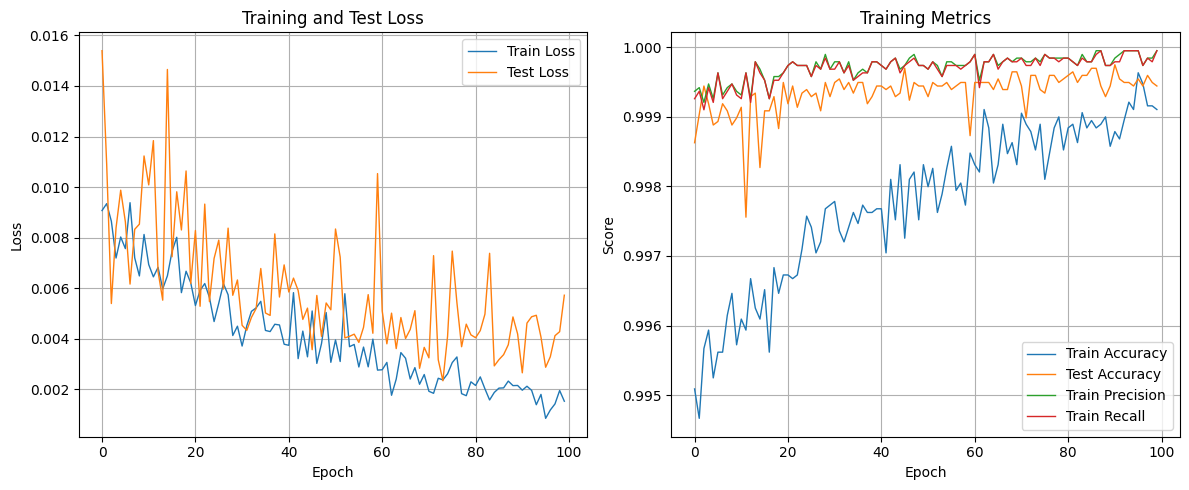

Final Evaluation:
154/154 [==============================] - 1s 9ms/step - loss: 0.0057 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994

Test Results - Loss: 0.0057, Acc: 0.9994, Precision: 0.9994, Recall: 0.9994


In [908]:
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall

# 1. Define precision/recall metrics
train_precision = Precision()
train_recall = Recall()

# 2. Modify training loop to track metrics
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []

test_losses = []
test_accuracies = []

# Training loop with metrics tracking
print("Training the student model using Knowledge Distillation...")
for epoch in range(100):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    train_precision.reset_states()
    train_recall.reset_states()
    
    for batch_idx, (x_batch, y_batch) in enumerate(train_dataset):
        batch_loss, batch_accuracy = train_step(x_batch, y_batch)
        
        # Update metrics
        student_pred = student_model(x_batch)
        train_precision.update_state(y_batch, student_pred)
        train_recall.update_state(y_batch, student_pred)
        
        epoch_loss += batch_loss
        epoch_accuracy += batch_accuracy
        
    # Calculate epoch metrics
    epoch_loss /= (batch_idx + 1)
    epoch_accuracy /= (batch_idx + 1)
    epoch_precision = train_precision.result().numpy()
    epoch_recall = train_recall.result().numpy()
    
    # Evaluate on test set
    test_results = student_model.evaluate(test_dataset, verbose=0)
    test_loss, test_acc = test_results[0], test_results[1]
    
    # Store metrics
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    train_precisions.append(epoch_precision)
    train_recalls.append(epoch_recall)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch {epoch+1}")
    print(f"Train - Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}")
    print(f"Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}\n")

# 3. Plot training/test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy/precision/recall
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(train_precisions, label='Train Precision')
plt.plot(train_recalls, label='Train Recall')
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation with precision/recall
student_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

print("Final Evaluation:")
test_loss, test_acc, test_precision, test_recall = student_model.evaluate(test_dataset)
print(f"\nTest Results - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

In [909]:
import keras
keras.__version__

'2.3.1'

In [910]:
import tensorflow as tf
tf.__version__

'2.2.0'

Teacher Model Confusion Matrix:


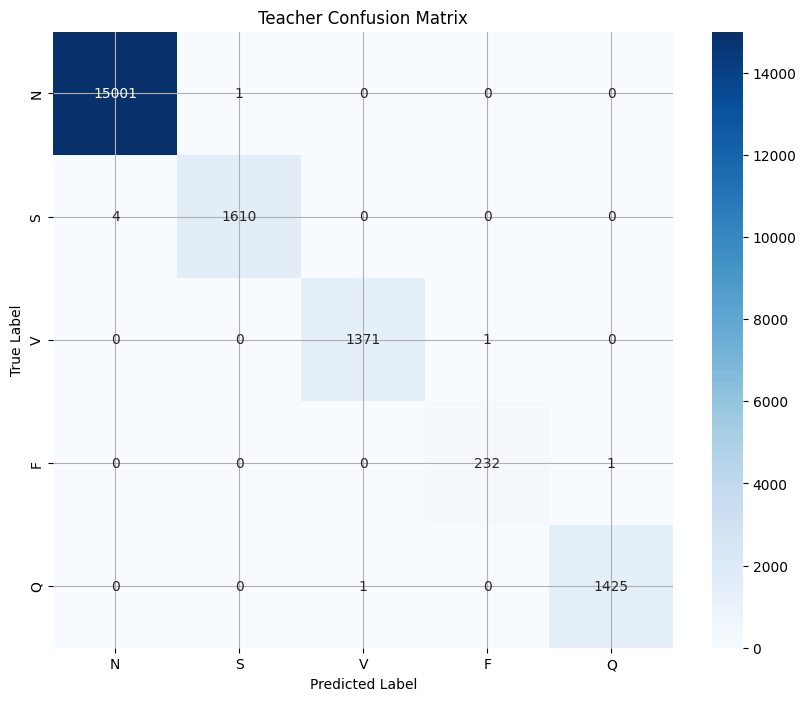

              precision    recall  f1-score   support

           N       1.00      1.00      1.00     15002
           S       1.00      1.00      1.00      1614
           V       1.00      1.00      1.00      1372
           F       1.00      1.00      1.00       233
           Q       1.00      1.00      1.00      1426

    accuracy                           1.00     19647
   macro avg       1.00      1.00      1.00     19647
weighted avg       1.00      1.00      1.00     19647


Student Model Confusion Matrix:


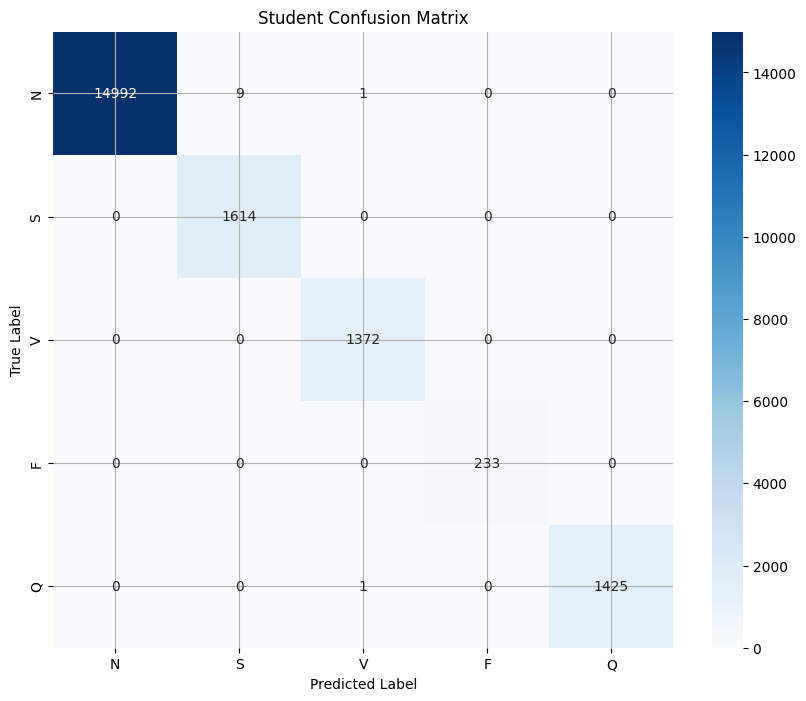

              precision    recall  f1-score   support

           N       1.00      1.00      1.00     15002
           S       0.99      1.00      1.00      1614
           V       1.00      1.00      1.00      1372
           F       1.00      1.00      1.00       233
           Q       1.00      1.00      1.00      1426

    accuracy                           1.00     19647
   macro avg       1.00      1.00      1.00     19647
weighted avg       1.00      1.00      1.00     19647



In [911]:
def plot_confusion_matrix(model, x_test, y_test, title='Confusion Matrix'):
    # Generate predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Classification report
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Replace class_names with your actual class labels
class_names = ['N', 'S', 'V', 'F', 'Q']  # MIT-BIH classes

# For Teacher Model
print("Teacher Model Confusion Matrix:")
plot_confusion_matrix(teacher_model, test_x, test_y, 'Teacher Confusion Matrix')

# For Student Model
print("\nStudent Model Confusion Matrix:")
plot_confusion_matrix(student_model, test_x, test_y, 'Student Confusion Matrix')

In [913]:
model.save("model.h5")
